In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1

Сначала объявим несколько полезных функций, которые пригодятся нам при анализе каждого из датасетов.

In [2]:
from scipy.stats import f as fisher
from scipy.stats import norm
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Lasso as LinRegL1
from sklearn.linear_model import Ridge as LinRegL2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as calc_r2

def fisher_test(model, original_df, modified_df, labels):
    model.fit(original_df, labels)
    original_res = model.predict(original_df)
    
    model.fit(modified_df, labels)
    modified_res = model.predict(modified_df)
    
    F = (original_res.std() / modified_res.std()) ** 2
    
    p_value = fisher.cdf(F, len(original_res) - 1, len(modified_res) - 1)
    
    return p_value

def draw_heatmap(df, figsize=(20,20)):
    corr_matrix = df.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
    
def draw_normal_by_mean_and_std(mu, sigma, **kwargs):
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.plot(x, norm.pdf(x, mu, sigma), **kwargs)
    
def draw_distributions(df, figsize=(8,8)):
    for col in df.columns:
        plt.hist(df[col], color='limegreen', label=col, alpha=0.5, density=True)
        draw_normal_by_mean_and_std(np.mean(df[col]), np.std(df[col]), color='royalblue', label='sample', alpha=0.5)
        plt.legend()
        plt.show()
    
def draw_dependencies(df, labels, figsize=(8,8)):
    for col in df.columns:
        plt.figure(figsize=figsize)
        plt.scatter(labels, df[col])
        plt.title(col)
        plt.show()
        
def print_scores(preds, y_real):
    for name, y_pred in preds.items():
        print("%s >\n\tmse: %f\n\tr2:  %f" % (name, mean_squared_error(y_real, y_pred), calc_r2(y_real, y_pred)))

## a

In [3]:
df1 = pd.read_csv('data_regr_hw1.csv', index_col=0)

df1.head()

,x1,x2,x3,y
1,1.070923,1.961657,1.694283,15.037262
2,0.094712,2.023003,-2.190803,-2.864616
3,0.262196,2.025097,2.008450,13.182666
4,0.452745,2.090940,-1.613448,1.730029
5,0.821185,2.160031,-0.282123,3.532601


In [4]:
labels1 = df1['y']

df1.drop('y', axis=1, inplace=True)

Посмотрим на распределения переменных:

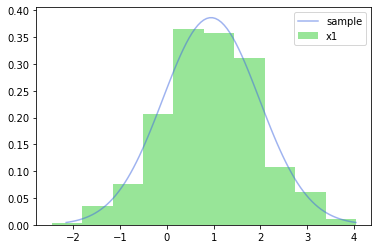

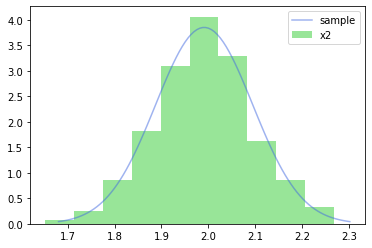

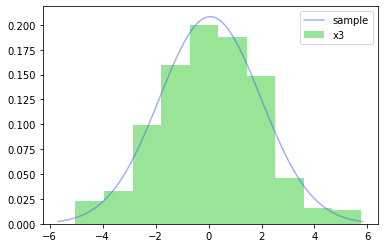

In [5]:
draw_distributions(df1, figsize=(4,4))

Распределены они довольно нормально. Посмотрим теперь на зависимости метки и переменных:

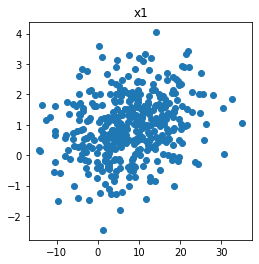

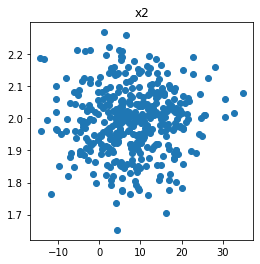

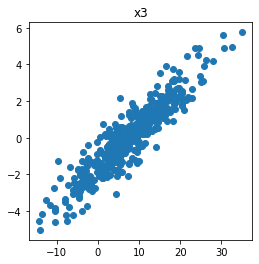

In [6]:
draw_dependencies(df1, labels1, figsize=(4,4))

Замечаем, что зависимости x1 и x2 вообще не чувствуются, в то время как x3 имеет чёткую линейную зависимость.

Посчитаем корреляции между признаками и метками:

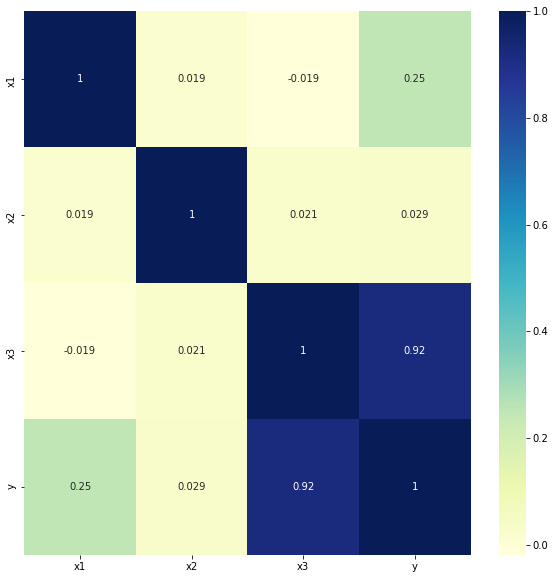

In [7]:
draw_heatmap(pd.concat([df1, labels1], axis=1), figsize=(10, 10))

Как можно видеть, корреляции между признаками незначительны, но очень четко проглядывается зависимость, которую мы обнаружили ранее с переменной x3, а ещё можно обратить внимание на то, что x1 тоже неким образом скоррелирована с метками.

Чтобы проверить это предположение, давайте обучим модель линейной регрессии на датасетах с выброшенными признаками и заметим, что признак x2 является несущественным, в то время как x3 практически обязателен, а x1 вносит ощутимый вклад:

In [8]:
print(fisher_test(LinReg(), df1, df1.drop('x1', axis=1), labels1))
print(fisher_test(LinReg(), df1, df1.drop('x2', axis=1), labels1))
print(fisher_test(LinReg(), df1, df1.drop('x3', axis=1), labels1))

0.7899278109849401
0.5000876301025147
0.9999999999999999


Давайте построим модель:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df1, labels1, test_size=0.2, shuffle=True, random_state=42)

model = LinReg()

model.fit(X_train, y_train)

model.coef_, model.intercept_

(array([2.24830127, 0.0688281 , 4.18721723]), 5.1319834284711865)

Посчитаем коэффициент детерминации:

In [10]:
calc_r2(model.predict(X_test), y_test)

0.9258114027151569

Здесь в который раз мы можем убедиться, что x2 можно выкинуть. Давайте построим модель без него:

In [11]:
excl_model = LinReg()

excl_model.fit(X_train.drop('x2', axis=1), y_train)

excl_model.coef_, model.intercept_

(array([2.24848747, 4.18728798]), 5.1319834284711865)

И для неё тоже посчитаем $R^2$:

In [12]:
calc_r2(excl_model.predict(X_test.drop('x2', axis=1)), y_test)

0.9257831282018661

Теперь посчитаем MSE для результатов моделей:

In [13]:
mean_squared_error(y_test, model.predict(X_test)), mean_squared_error(y_test, excl_model.predict(X_test.drop('x2', axis=1)))

(6.049573519918302, 6.051830526411449)

Можно видеть, что MSE вырастает незначительно, а $R^2$ незначительно падает, так, что принять решение о выкидывании x2 сложно. Я бы выкинул.

## 2

In [14]:
df2 = pd.read_csv('data_regr_hw2.csv', index_col=0)

df2.head()

,x1,x2,x3,x4,y
1,0.399327,2.241212,-1.308239,-0.504552,13.645627
2,1.559851,3.233286,-0.556126,2.159584,19.633818
3,0.885058,2.166791,-0.989198,-0.167548,15.958832
4,0.703000,2.413546,0.825297,4.306648,28.722052
5,1.090116,2.882903,1.106407,5.265112,26.940867


In [15]:
labels2 = df2['y']

df2.drop('y', axis=1, inplace=True)

Посмотрим на распределение переменных:

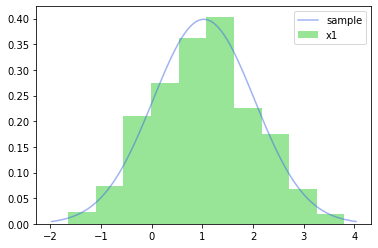

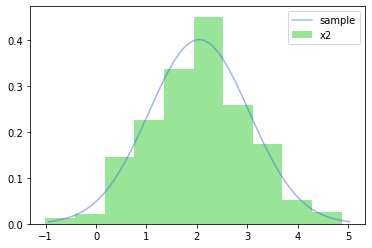

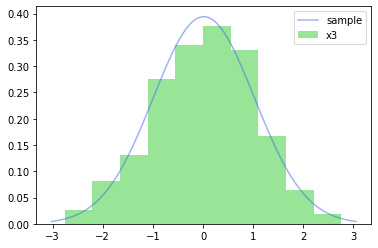

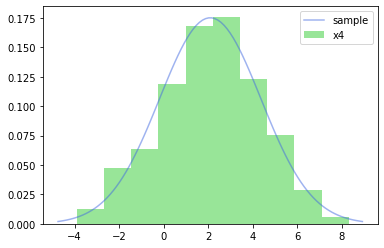

In [16]:
draw_distributions(df2, figsize=(4,4))

Тут переменные тоже выглядят нормально распределёнными, не будем их модифицировать.

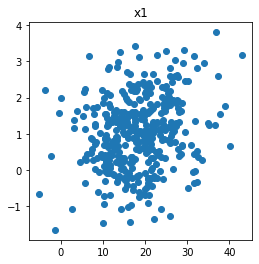

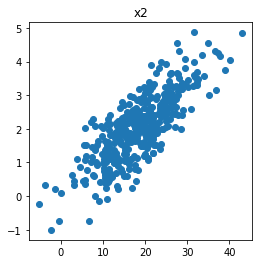

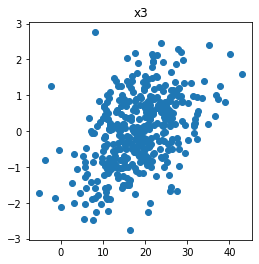

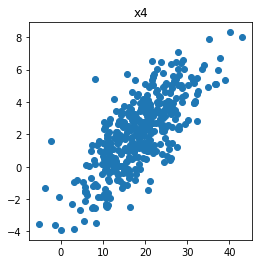

In [17]:
draw_dependencies(df2, labels2, figsize=(4,4))

Можно заметить, что признак x1 не выглядит зависимым от меток, в то время как остальные кажутся в какой-то мере коррелирующими с ним. Посчитаем корреляции:

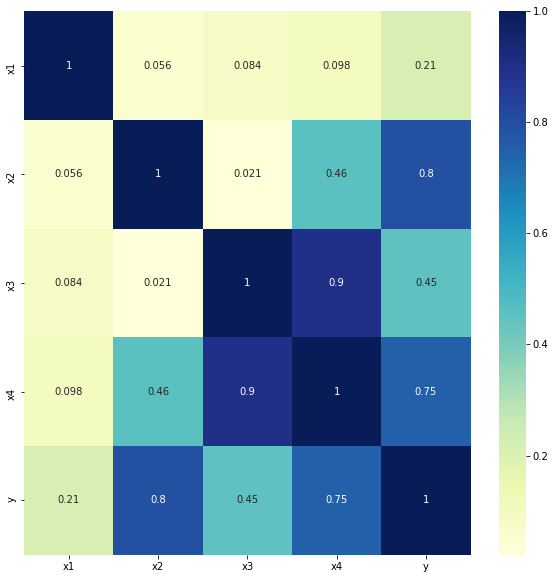

In [18]:
draw_heatmap(pd.concat([df2, labels2], axis=1), figsize=(10, 10))

Здесь можно заметить, что признаки x3 и x4 кореллируют между собой очень сильно, при этом x4 ещё довольно сильно коррелирует с x2. У нас есть сильная группа корреляции между признаками x2, x3, x4 и метками. Давайте опять попробуем обучить модели и посмотреть, что меняет выбрасывание тех или иных признаков:

In [19]:
print(fisher_test(LinReg(), df2, df2.drop('x1', axis=1), labels2))
print(fisher_test(LinReg(), df2, df2.drop('x2', axis=1), labels2))
print(fisher_test(LinReg(), df2, df2.drop('x3', axis=1), labels2))
print(fisher_test(LinReg(), df2, df2.drop('x4', axis=1), labels2))

0.5857908133184724
0.5206308003683209
0.5002727015028647
0.5009034179488707


Все признаки кажутся не очень значимыми, однако на самом деле стоит понимать, что в модели с сильно коррелирующими признаками какие-то из них, скорее всего, дублируют информацию, которую мы уже имеем. Попробуем обучить модель с L1-регуляризацией и посмотреть, какие её коэффициенты зануляются:

In [20]:
model = LinRegL1()

model.fit(df2, labels2)

model.coef_, model.intercept_

(array([0.06338194, 3.30500789, 0.        , 1.61518464]), 8.200835259939257)

Можно видеть, что модель обнулила коэффициент при x3 и практически обнулила коэффициент при x1. При этом F-тест показывал, что x3 значимый признак!

Давайте теперь повторим его, выкинув x3 из всего датасета.

In [21]:
df2_mod = df2.drop('x3', axis=1)

In [22]:
print(fisher_test(LinReg(), df2_mod, df2_mod.drop('x1', axis=1), labels2))
print(fisher_test(LinReg(), df2_mod, df2_mod.drop('x2', axis=1), labels2))
print(fisher_test(LinReg(), df2_mod, df2_mod.drop('x4', axis=1), labels2))

0.586421406402259
0.9998723989455736
0.9908887149138782


Теперь тест показывает значимость x2 и x4 и незначимость x1. Опять же, построим модель и посчитаем метрику для того, чтобы понять, насколько существенно она ухудшается, если выкинуть x1.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df2_mod, labels2, test_size=0.2, shuffle=True, random_state=42)

model = LinReg()

model.fit(X_train, y_train)

model.coef_, model.intercept_

(array([1.14987775, 4.36320743, 1.52999065]), 5.032830137810009)

В отличии от первой ситуации, здесь модель назначает довольно весомый коэффициент при x1, хотя F-тест показывал, что его можно выкинуть.

In [24]:
calc_r2(model.predict(X_test), y_test)

0.7931313574889979

Не очень такой коэффициент детерминации. Может, x1 всё же не очень хорош? Построим модель без него:

In [25]:
excl_model = LinReg()

excl_model.fit(X_train.drop('x1', axis=1), y_train)

excl_model.coef_, model.intercept_

(array([4.39092616, 1.56444756]), 5.032830137810009)

In [26]:
calc_r2(excl_model.predict(X_test.drop('x1', axis=1)), y_test)

0.790573070909533

Посчитаем метрику:

In [27]:
mean_squared_error(y_test, model.predict(X_test)), mean_squared_error(y_test, excl_model.predict(X_test.drop('x1', axis=1)))

(10.134035285164824, 9.836729017240902)

Вот здесь получилось совсем круто - мы выяснили, что удаление из модели x1 улучшает и MSE, и $R^2$. У нас 2 голоса против 1, к сожалению участнику x1 придется покинуть программу.

## 3

In [28]:
df3 = pd.read_csv('data_regr_hw3.csv', index_col=0)

df3.head()

,x1,x2,x3,x4,y
1,-0.445720,3.133175,0.696999,-1.203788,8.818393
2,1.819250,1.883428,-0.302519,-0.531105,6.747099
3,-0.103915,1.909790,-0.115184,0.905218,6.947370
4,-0.126001,1.155766,0.748187,0.626164,7.812094
5,2.944582,0.934712,1.437004,1.288921,13.187132


In [29]:
labels3 = df3['y']

df3.drop('y', axis=1, inplace=True)

Посмотрим на распределение переменных:

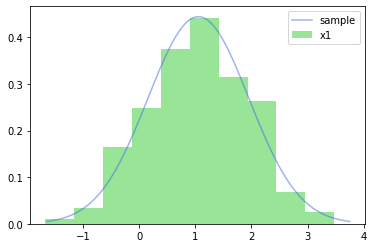

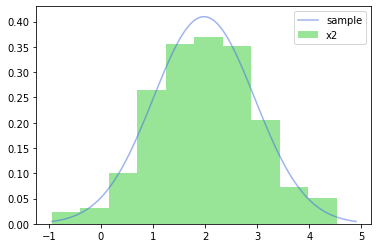

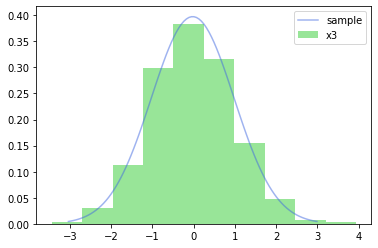

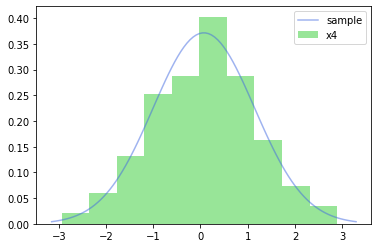

In [30]:
draw_distributions(df3, figsize=(4,4))

Вроде нормально, пока что не будем принимать решение о модификации, посмотрим на зависимости:

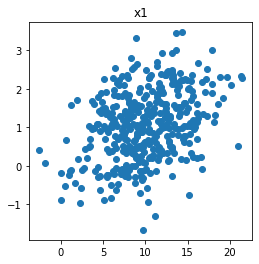

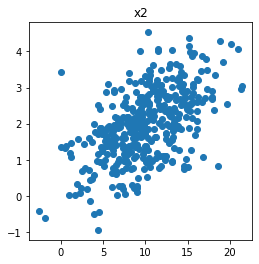

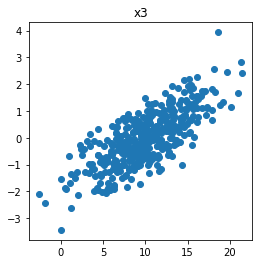

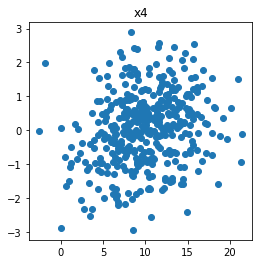

In [31]:
draw_dependencies(df3, labels3, figsize=(4,4))

x3 немного кажется квадратичной с некоторым сдвигом, давайте добавим параметр x5, равный квадрату от x3 со сдвигом (мы немного сломаем этот параметр, округлив его вверх до нуля):

In [32]:
df3['x5'] = (df3['x3'] + 4) ** 2

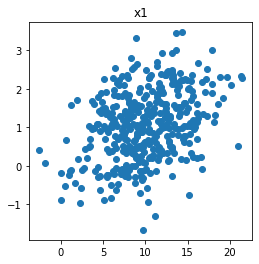

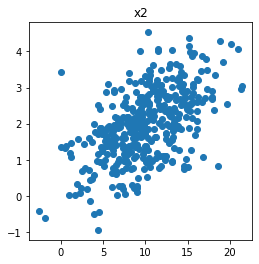

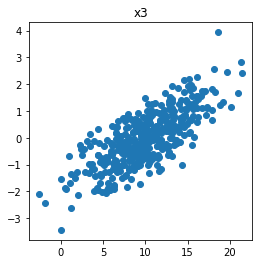

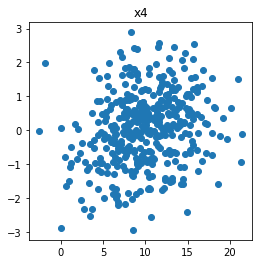

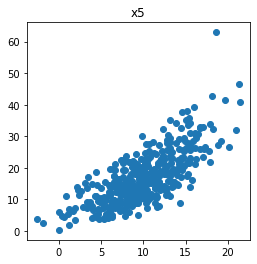

In [33]:
draw_dependencies(df3, labels3, figsize=(4,4))

Посчитаем корреляции между признаками:

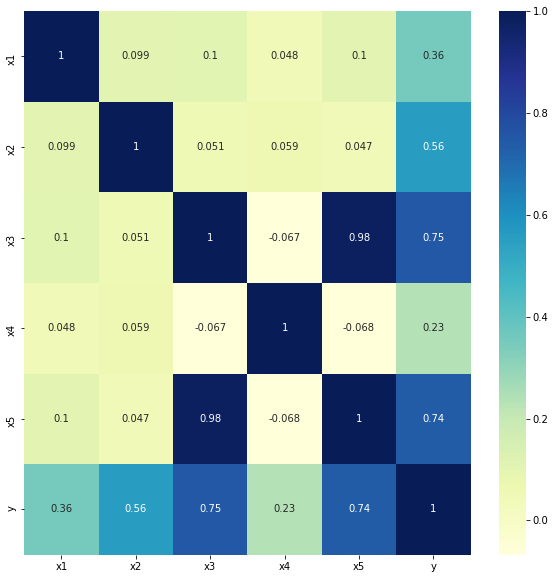

In [34]:
draw_heatmap(pd.concat([df3, labels3], axis=1), figsize=(10,10))

Абсолютно объяснима корреляция между x3 и x5, кроме того можно видеть, что метки довольно сильно коррелируют со всеми признаками, кроме x4, с ним тоже, но не так сильно.

In [35]:
print(fisher_test(LinReg(), df3, df3.drop('x1', axis=1), labels3))
print(fisher_test(LinReg(), df3, df3.drop('x2', axis=1), labels3))
print(fisher_test(LinReg(), df3, df3.drop('x3', axis=1), labels3))
print(fisher_test(LinReg(), df3, df3.drop('x4', axis=1), labels3))
print(fisher_test(LinReg(), df3, df3.drop('x5', axis=1), labels3))

0.6976493766347766
0.9973088199395227
0.5690310730308404
0.7358067949048581
0.5002218178426576


Можно сразу увидеть, что x2 кажется довольно важным признаком, а остальные ну такое себе. Однако не будем спешить и сделаем регуляризованную модель, которая позволит отобрать признаки.

In [36]:
model = LinRegL1()

model.fit(df3, labels3)

model.coef_, model.intercept_

(array([0.        , 1.14853467, 0.        , 0.14534831, 0.34765776]),
 1.8501681038138376)

Как можно видеть, коэффициенты при x1 и x3 зануляются, что позволяет сделать вывод об их ненужности.

In [37]:
df3_mod = df3.drop(['x1', 'x3'], axis=1)

In [38]:
print(fisher_test(LinReg(), df3_mod, df3_mod.drop('x2', axis=1), labels3))
print(fisher_test(LinReg(), df3_mod, df3_mod.drop('x4', axis=1), labels3))
print(fisher_test(LinReg(), df3_mod, df3_mod.drop('x5', axis=1), labels3))

0.9996735099858968
0.7712479135686652
0.9999999999999999


Как мы видим по результатам теста теперь, x2 и x5 являются значимыми признаками, а x4 - ну не очень. Давайте опять проверим метрики модели с ним и без него.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df3_mod, labels3, test_size=0.2, shuffle=True, random_state=42)

model = LinReg()

model.fit(X_train, y_train)

model.coef_, model.intercept_

(array([2.14119747, 0.94269957, 0.3636663 ]), -0.4202443565834404)

In [40]:
calc_r2(model.predict(X_test), y_test)

0.8227754094541146

Здесь модель даже даёт достаточно весомый коэффициент при x4, наверное, он всё же не так незначителен. Всё равно проверим!

In [41]:
excl_model = LinReg()

excl_model.fit(X_train.drop('x4', axis=1), y_train)

excl_model.coef_, model.intercept_

(array([2.21605774, 0.34963566]), -0.4202443565834404)

In [42]:
calc_r2(excl_model.predict(X_test.drop('x4', axis=1)), y_test)

0.6638242944747645

Посчитаем метрику:

In [43]:
mean_squared_error(y_test, model.predict(X_test)), mean_squared_error(y_test, excl_model.predict(X_test.drop('x4', axis=1)))

(2.1376948228955603, 3.3844145473198024)

Как можно наблюдать, ошибка модели существенно возросла при исключении x4, а $R^2$ *очень* сильно упал. Поэтому из итоговой модели мы не будем его исключать.

## 4

In [44]:
df4 = pd.read_csv('data_regr_hw3.csv', index_col=0)

df4.head()

,x1,x2,x3,x4,y
1,-0.445720,3.133175,0.696999,-1.203788,8.818393
2,1.819250,1.883428,-0.302519,-0.531105,6.747099
3,-0.103915,1.909790,-0.115184,0.905218,6.947370
4,-0.126001,1.155766,0.748187,0.626164,7.812094
5,2.944582,0.934712,1.437004,1.288921,13.187132


In [45]:
labels4 = df4['y']

df4.drop('y', axis=1, inplace=True)

Посмотрим на рспределения переменных:

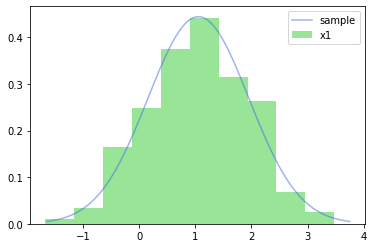

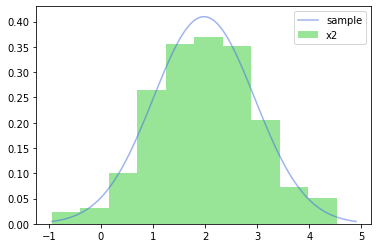

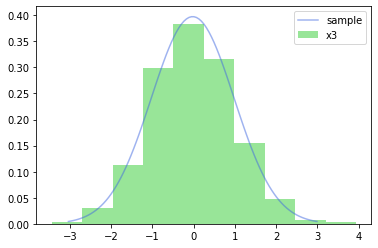

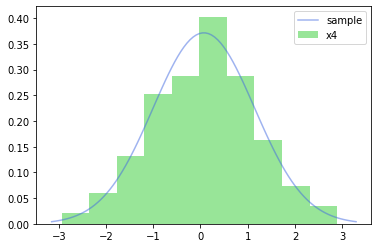

In [46]:
draw_distributions(df4, figsize=(4,4))

Всё ещё довольно нормальное распределение, не будем делать выводов о модификации данных пока что.

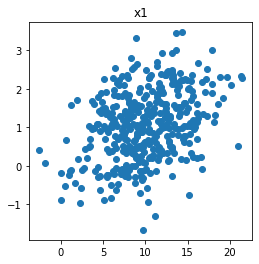

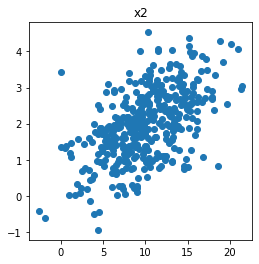

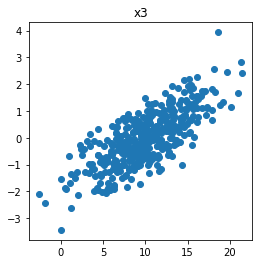

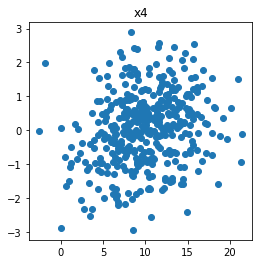

In [47]:
draw_dependencies(df4, labels4, figsize=(4,4))

Явных зависимостей либо не видно, либо они линейные. Не будем ничего модифицировать.

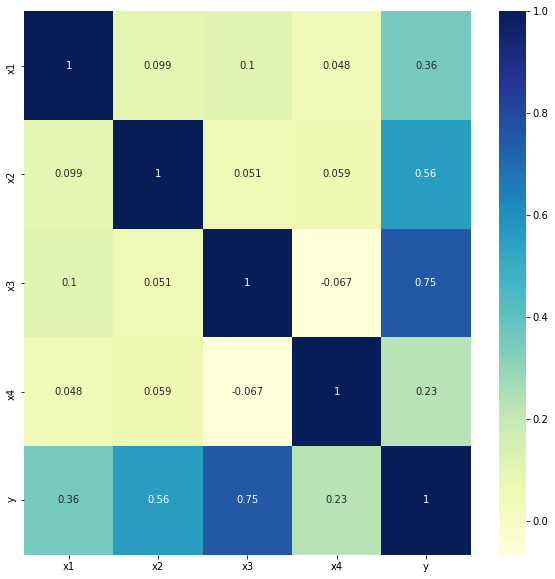

In [48]:
draw_heatmap(pd.concat([df4, labels4], axis=1), figsize=(10, 10))

Между признаками, так сказать, No Correlation. Однако это не значит, что у нас нет бОльшего количество коррелирующих признаков. x1, x2 и x3, возможно, как раз коррелируют все вместе.

In [49]:
print(fisher_test(LinReg(), df4, df4.drop('x1', axis=1), labels4))
print(fisher_test(LinReg(), df4, df4.drop('x2', axis=1), labels4))
print(fisher_test(LinReg(), df4, df4.drop('x3', axis=1), labels4))
print(fisher_test(LinReg(), df4, df4.drop('x4', axis=1), labels4))

0.6977113628599149
0.9973043960602208
0.9999999999999882
0.7357182787095615


Мы можем видеть, что x2 и x3 считаются довольно значимыми, в то время как остальные - нет. Давайте попробуем опять отобрать признаки при помощи L1-регуляризации.

In [50]:
model = LinRegL1()

model.fit(df4, labels4)

model.coef_, model.intercept_

(array([0.02278677, 1.18354379, 2.03725995, 0.08895194]), 7.656398104805627)

Это очень забавно, никакой коэффициент не обнулился, однако есть два довольно близих к нулю. Мы не сдадимся и продолжим проводить эксперименты, на этот раз пройдёмся по метрикам:

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df2_mod, labels2, test_size=0.2, shuffle=True, random_state=42)

model = LinReg()

data = {
    "full" : lambda x : x,
    "no x1" : lambda x : x.drop('x1', axis=1),
    "no x4" : lambda x : x.drop('x4', axis=1),
    "no x1 and x4" : lambda x : x.drop(['x1', 'x4'], axis=1)
}

preds = {}

for name, dropper in data.items():
    model.fit(dropper(X_train), y_train)
    preds[name] = model.predict(dropper(X_test))
    
print_scores(preds, y_test)

full >
	mse: 10.134035
	r2:  0.825598
no x1 >
	mse: 9.836729
	r2:  0.830714
no x4 >
	mse: 21.295069
	r2:  0.633522
no x1 and x4 >
	mse: 22.112828
	r2:  0.619449


Как можно видеть, выкидывание x1 помогло. Давайте повторим итерацию поиска:

In [52]:
df4_mod = df4.drop('x1', axis=1)

In [53]:
print(fisher_test(LinReg(), df4_mod, df4_mod.drop('x2', axis=1), labels4))
print(fisher_test(LinReg(), df4_mod, df4_mod.drop('x3', axis=1), labels4))
print(fisher_test(LinReg(), df4_mod, df4_mod.drop('x4', axis=1), labels4))

0.9994867312988852
0.9999999999999999
0.7676842171261757


Видим, что x4 не так сильно важен, однако выше мы уже видели, что его удаление приводит к существенному ухудшению скора модели.

Посмотрим ещё раз на L1-регуляризацию:

In [54]:
model = LinRegL1()

model.fit(df4_mod, labels4)

model.coef_, model.intercept_

(array([1.18546335, 2.03936893, 0.08990394]), 7.6766089445273895)

Тоже видим, что она назначает маленькую значимость параметру x4, однако не настолько маленькую, чтобы выкинуть его.

# 2

In [55]:
df = pd.read_csv('Birthweight.csv')

df.head()

,ID,Length,Birthweight,Headcirc,Gestation,smoker,mage,mnocig,mheight,mppwt,fage,fedyrs,fnocig,fheight,lowbwt,mage35
0,1360,56,4.55,34,44,0,20,0,162,57,23,10,35,179,0,0
1,1016,53,4.32,36,40,0,19,0,171,62,19,12,0,183,0,0
2,462,58,4.10,39,41,0,35,0,172,58,31,16,25,185,0,1
3,1187,53,4.07,38,44,0,20,0,174,68,26,14,25,189,0,0
4,553,54,3.94,37,42,0,24,0,175,66,30,12,0,184,0,0


Сразу видим здесь признак `mage35`, который можно удалить - мы будем работать в первую очередь с числовыми признаками. Кроме того, по заданию удаляем признак `length`.

In [56]:
labels = df['Birthweight']

df.drop(['ID', 'Birthweight', 'Length', 'mage35'], axis=1, inplace=True)

df.head()

,Headcirc,Gestation,smoker,mage,mnocig,mheight,mppwt,fage,fedyrs,fnocig,fheight,lowbwt
0,34,44,0,20,0,162,57,23,10,35,179,0
1,36,40,0,19,0,171,62,19,12,0,183,0
2,39,41,0,35,0,172,58,31,16,25,185,0
3,38,44,0,20,0,174,68,26,14,25,189,0
4,37,42,0,24,0,175,66,30,12,0,184,0


Давайте нарисуем хитмап, отражающий корреляции признаков:

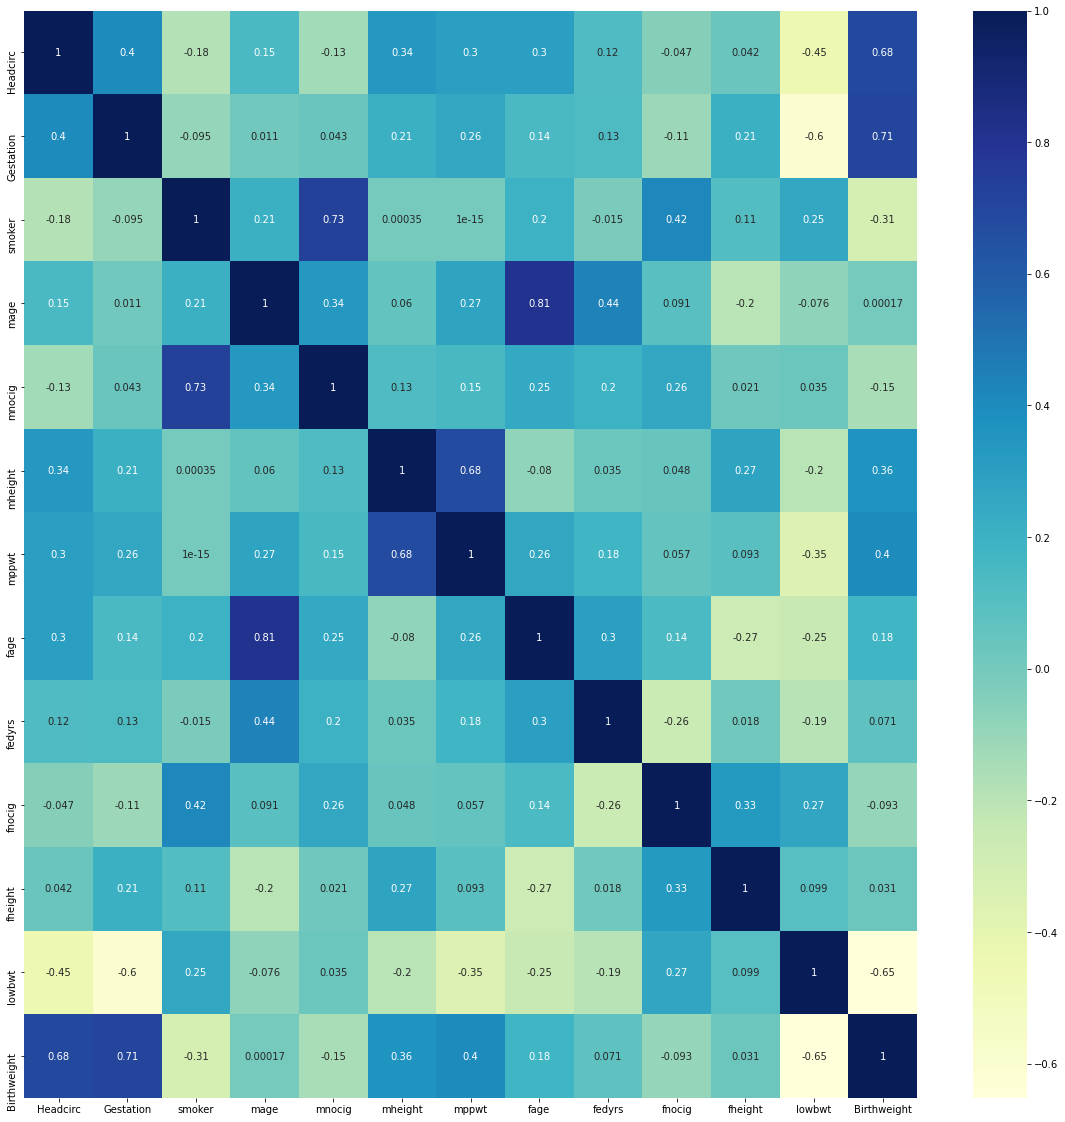

In [57]:
draw_heatmap(pd.concat([df, labels], axis=1), figsize=(20, 20))

Сразу можно выделить довольно значимые признаки (мы пока ещё не знаем, не коррелируют ли они между собой и не придется ли нам их отбирать):

- Headcirc
- Gestation
- smoker
- mheight
- mppwt
- lowbwt

`lowbwt` вообще забавный признак - он абсолютно очевидно коррелирует с меткой ответа, возможно, использовать его будет не совсем честно.

Но ничего, отберём себе признаков и пойдём дальше:

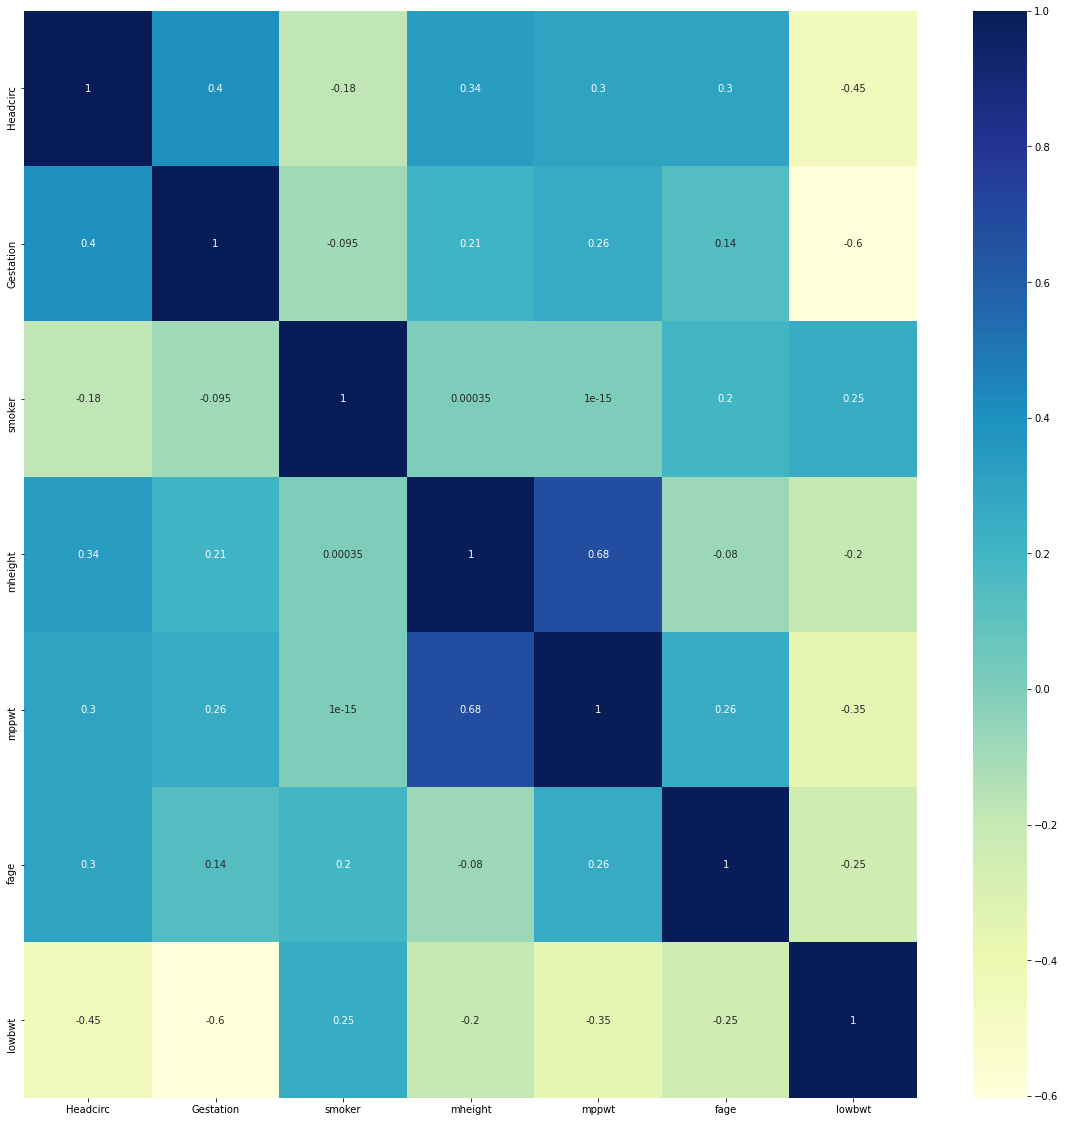

In [58]:
edf = df.drop(['mage', 'mnocig', 'fedyrs', 'fnocig', 'fheight'], axis=1)

draw_heatmap(edf, figsize=(20, 20))

Давайте сразу устроим на этих данных линейную регрессию с L1-регуляризацией, чтобы отобрать признаки:

In [59]:
model = LinRegL1()

model.fit(edf, labels)

model.coef_, model.intercept_

(array([ 0.        ,  0.00596851, -0.        ,  0.        ,  0.01330302,
         0.        , -0.        ]),
 2.314024665758453)

Забавно, что регуляризация уничтожила практически все признаки. Возможно, стоит подобрать ей поменьше коэффициент, чтобы она была не такой агрессивной.

In [60]:
model = LinRegL1(alpha=.5)

model.fit(edf, labels)

model.coef_, model.intercept_

(array([ 0.04228553,  0.06345632, -0.        ,  0.00134428,  0.01270682,
         0.        , -0.        ]),
 -1.588616376048794)

Вот, теперь она чуть мягче. Опять посчитаем метрики чтобы попытаться понять, какие модели справляются лучше:

In [61]:
X_train, X_test, y_train, y_test = train_test_split(edf, labels, test_size=0.2, shuffle=True, random_state=42)

model = LinReg()

data = {
    "full" : lambda x : x,
    "Gestation and mppwt" : lambda x : x[['Gestation', 'mppwt']],
    "Headcirc, Gestation, mheight and mppwt" : lambda x : x[['Headcirc', 'Gestation', 'mheight', 'mppwt']],
    "Gestation, mppwt and lowbwt" : lambda x : x[['Gestation', 'mppwt', 'lowbwt']]
}

preds = {}

for name, dropper in data.items():
    model.fit(dropper(X_train), y_train)
    preds[name] = model.predict(dropper(X_test))
    
print_scores(preds, y_test)

full >
	mse: 0.083408
	r2:  0.794297
Gestation and mppwt >
	mse: 0.169679
	r2:  0.581532
Headcirc, Gestation, mheight and mppwt >
	mse: 0.088944
	r2:  0.780643
Gestation, mppwt and lowbwt >
	mse: 0.147195
	r2:  0.636982


Лучше всего справляется, несмотря на удаление регуляризацией, полная модель. Давайте покрутим коэффициент регуляризации ещё, чтобы выкинуть только пару признаков:

In [62]:
model = LinRegL1(alpha=.1)

model.fit(edf, labels)

model.coef_, model.intercept_

(array([ 0.09786245,  0.1028872 , -0.        ,  0.00156098,  0.01148451,
        -0.00126539, -0.        ]),
 -4.98540577552608)

Видим, что существенное уменьшение коэффициента регуляризации приводит к добавлению ещё одного признака:

In [63]:
model = LinReg()

data['almost full'] = lambda x : x[['Headcirc', 'Gestation', 'mheight', 'mppwt', 'fage']]

model.fit(data['almost full'](X_train), y_train)
preds['almost full'] = model.predict(data['almost full'](X_test))
    
print_scores(preds, y_test)

full >
	mse: 0.083408
	r2:  0.794297
Gestation and mppwt >
	mse: 0.169679
	r2:  0.581532
Headcirc, Gestation, mheight and mppwt >
	mse: 0.088944
	r2:  0.780643
Gestation, mppwt and lowbwt >
	mse: 0.147195
	r2:  0.636982
almost full >
	mse: 0.091986
	r2:  0.773142


Черт, отбор признаков совсем не работает. YOLO, давайте попробуем взять ВСЕ признаки и обучить модель на них.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, shuffle=True, random_state=42)

model = LinReg()

data['edf full'] = lambda x : x.drop(['mage', 'mnocig', 'fedyrs', 'fnocig', 'fheight'], axis=1)

preds = {}

for name, dropper in data.items():
    model.fit(dropper(X_train), y_train)
    preds[name] = model.predict(dropper(X_test))
    
print_scores(preds, y_test)

full >
	mse: 0.130827
	r2:  0.677350
Gestation and mppwt >
	mse: 0.169679
	r2:  0.581532
Headcirc, Gestation, mheight and mppwt >
	mse: 0.088944
	r2:  0.780643
Gestation, mppwt and lowbwt >
	mse: 0.147195
	r2:  0.636982
almost full >
	mse: 0.091986
	r2:  0.773142
edf full >
	mse: 0.083408
	r2:  0.794297


Что же, отбирать признаки всё же надо. Давайте не будем полагаться на интуицию, как в прошлый раз, а сделаем это более интеллектуально - опять же, при помощи регуляризации, но на всём датасете:

In [65]:
model = LinRegL1(alpha=.2)

model.fit(df, labels)

for i in range(len(model.coef_)):
    print("%s : %f" % (model.feature_names_in_[i], model.coef_[i]))

Headcirc : 0.073564
Gestation : 0.098074
smoker : -0.000000
mage : -0.000000
mnocig : -0.006374
mheight : 0.005066
mppwt : 0.011966
fage : 0.000000
fedyrs : -0.000000
fnocig : 0.000000
fheight : -0.004077
lowbwt : -0.000000


Давайте попробуем вновь выкинуть обнулённые параметры:

In [66]:
model = LinReg()

data['l1, a=.2 from full'] = lambda x : x.drop(['smoker', 'mage', 'fage', 'fedyrs', 'fnocig', 'lowbwt'], axis=1)

model.fit(data['l1, a=.2 from full'](X_train), y_train)
preds['l1, a=.2 from full'] = model.predict(data['l1, a=.2 from full'](X_test))
    
print_scores(preds, y_test)

full >
	mse: 0.130827
	r2:  0.677350
Gestation and mppwt >
	mse: 0.169679
	r2:  0.581532
Headcirc, Gestation, mheight and mppwt >
	mse: 0.088944
	r2:  0.780643
Gestation, mppwt and lowbwt >
	mse: 0.147195
	r2:  0.636982
almost full >
	mse: 0.091986
	r2:  0.773142
edf full >
	mse: 0.083408
	r2:  0.794297
l1, a=.2 from full >
	mse: 0.096118
	r2:  0.762951


Кажется, L1-регуляризация не делает ничего хорошего в этой ситуации вообще. Ну что же, давайте тогда возьмём лучшую на дыннй момент модель, `edf full` и попробуем подобрать её параметры при помощи GridCVSearch.

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet as Elastic

X_train, X_test, y_train, y_test = train_test_split(edf, labels, test_size=0.2, shuffle=True, random_state=42)

pipeline = Pipeline([('regressor', Elastic())])
params = [{
    'regressor__l1_ratio': [0.5, 0.1, 0.02, 0.004, 0.],
    'regressor__max_iter': [250, 500, 1000, 2000],
    'regressor__alpha' : [1, 0.5, 0.02, 0.004, 0.],
    'regressor__selection' : ['cyclic', 'random'],
    'regressor__random_state' : [42]
}]

best = GridSearchCV(pipeline, n_jobs=4, param_grid=params, scoring='neg_mean_squared_error', cv=5)
best.fit(X_train, y_train)

best.best_params_

/home/covariance/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.095e+00, tolerance: 1.010e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


{'regressor__alpha': 1,
 'regressor__l1_ratio': 0.0,
 'regressor__max_iter': 250,
 'regressor__random_state': 42,
 'regressor__selection': 'cyclic'}

Как можно видеть, поиск параметров предлагает вообще убрать L1, давайте так и поступим.

In [68]:
pipeline = Pipeline([('regressor', LinRegL2())])
params = [{
    'regressor__max_iter': [250, 500, 1000, 2000],
    'regressor__alpha' : [1, 0.5, 0.02, 0.004, 0.],
    'regressor__tol' : [1e-2, 1e-3, 1e-4],
    'regressor__random_state' : [42]
}]

best = GridSearchCV(pipeline, n_jobs=4, param_grid=params, scoring='neg_mean_squared_error', cv=5)
best.fit(X_train, y_train)

best.best_params_

{'regressor__alpha': 1,
 'regressor__max_iter': 250,
 'regressor__random_state': 42,
 'regressor__tol': 0.01}

Соберём лучшую модельку:

In [69]:
best_model = LinRegL2(alpha=1, max_iter=250, tol=1e-2, random_state=42)

best_model.fit(X_train, y_train)

best_model.coef_, best_model.intercept_

(array([ 0.08760059,  0.10820114, -0.15087059,  0.01230935,  0.00745376,
         0.00251468, -0.22521827]),
 -6.362218304444059)

In [70]:
pred = best_model.predict(X_test)

mean_squared_error(pred, y_test), calc_r2(pred, y_test)

(0.07748429406151605, 0.8510208835854047)

In [71]:
usual_linreg = LinReg()

usual_linreg.fit(X_train, y_train)

usual_linreg.coef_, usual_linreg.intercept_

(array([ 0.08662428,  0.10475608, -0.15060957,  0.01344831,  0.00586686,
         0.00177395, -0.33518967]),
 -6.256195139196346)

In [72]:
pred = usual_linreg.predict(X_test)

mean_squared_error(pred, y_test), calc_r2(pred, y_test)

(0.08340780886414, 0.8536716858139324)

Ура, L2-регуляризацию к черту! Даёшь обычную линейную регрессию!

# 3

Собранные данные лежат в файле `planets.csv`.

In [73]:
df = pd.read_csv('planets.csv')

df.head()

,Name,SemiMajorAxis,Period
0,Меркурий,0.387098,87.968434
1,Венера,0.723330,224.695435
2,Земля,1.000001,365.242190
3,Марс,1.523679,686.929710
4,Юпитер,5.202603,4330.595765


У нас один признак, давайте попробуем добавить в датасет его степени (*мы же вообще не знаем какой должен получиться ответ*).

In [74]:
labels = df['Period']

df.drop(['Period', 'Name'], axis=1, inplace=True)

df.rename({'SemiMajorAxis' : 'ax'}, axis=1, inplace=True)

df.head()

,ax
0,0.387098
1,0.723330
2,1.000001
3,1.523679
4,5.202603


In [75]:
for i in [-1, 0.5, 1.5, 2, 2.5, 3]:
    df['ax_' + str(i)] = df['ax'] ** i
    
df.head()

,ax,ax_-1,ax_0.5,ax_1.5,ax_2,ax_2.5,ax_3
0,0.387098,2.583323,0.622172,0.240842,0.149845,0.093229,0.058005
1,0.723330,1.382495,0.850488,0.615183,0.523206,0.444980,0.378451
2,1.000001,0.999999,1.000001,1.000002,1.000002,1.000003,1.000003
3,1.523679,0.656306,1.234374,1.880790,2.321599,2.865721,3.537372
4,5.202603,0.192211,2.280922,11.866730,27.067080,61.737886,140.819277


Давайте рисовать!

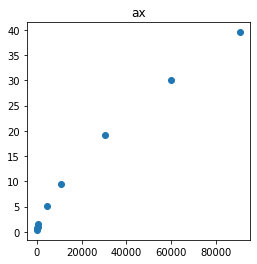

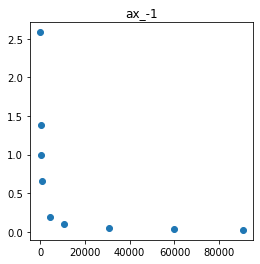

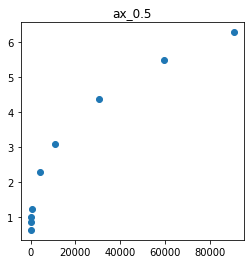

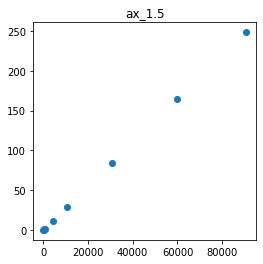

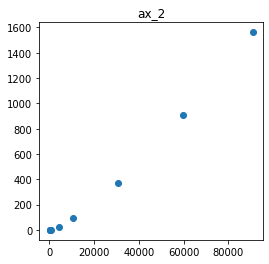

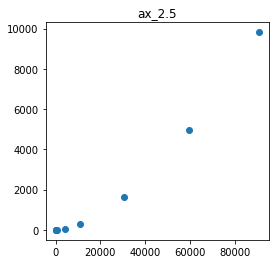

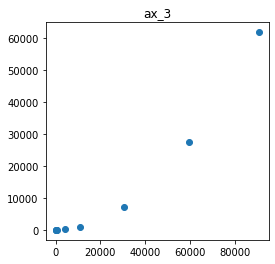

In [76]:
draw_dependencies(df, labels, figsize=(4,4))

(*конечно же я не знаю, почему `ax_1.5` так похоже на линию*)

Сначала поскейлим признаки, потому что они ну уж слишком большие:

In [77]:
from sklearn.preprocessing import StandardScaler as SScaler

scaler = SScaler()

scaler.fit(df)

scaler.transform(df)

array([[-0.84322437,  2.33785892, -1.08384025, -0.71063939, -0.63229855,
        -0.58044644, -0.54287161],
       [-0.81863111,  0.87062549, -0.97042597, -0.70621284, -0.63158043,
        -0.5803368 , -0.54285549],
       [-0.79839432,  0.4032719 , -0.89615665, -0.70166241, -0.63066337,
        -0.58016379, -0.54282423],
       [-0.76009048, -0.01666982, -0.77973319, -0.69124718, -0.62812143,
        -0.57958222, -0.54269659],
       [-0.49099991, -0.58372452, -0.25986789, -0.57316453, -0.58052629,
        -0.56123089, -0.53579102],
       [-0.17265555, -0.69070158,  0.14258353, -0.36423683, -0.45698863,
        -0.49250769, -0.49899461],
       [ 0.5341725 , -0.75500138,  0.7847647 ,  0.28277695,  0.07781377,
        -0.07575257, -0.1858148 ],
       [ 1.33085075, -0.77799933,  1.33287527,  1.24027467,  1.11122423,
         0.9702974 ,  0.83032951],
       [ 2.01897248, -0.78765968,  1.72980046,  2.22411155,  2.3711407 ,
         2.479723  ,  2.56151883]])

Давайте построим модель с регуляризацией (спойлер: пологаю, она нам не сделает ничего хорошего):

In [78]:
model = LinRegL1()

model.fit(df, labels)

model.coef_, model.intercept_

(array([ 1.40607031e+03, -2.75194968e+02, -2.96223412e+03,  1.25794369e+02,
         6.34265038e+00,  6.55972728e-01,  6.73146304e-02]),
 2064.7637245541773)

Казалось бы, ерунда, но сразу становится видно, что некоторые столбцы можно выкинуть:

In [79]:
df.drop(['ax_2', 'ax_2.5', 'ax_3'], axis=1, inplace=True)

In [80]:
model = LinReg()

model.fit(df, labels)

model.coef_, model.intercept_

(array([-389.47075259,  171.93672395, 1156.15552936,  401.66248231]),
 -999.6099758290948)

Сначала воспользуемся методами решения задачи, как будто она очень абстрактная, а не привязана к жизни.

In [81]:
print(fisher_test(LinReg(), df, df.drop('ax_-1', axis=1), labels))
print(fisher_test(LinReg(), df, df.drop('ax_0.5', axis=1), labels))
print(fisher_test(LinReg(), df, df.drop('ax', axis=1), labels))
print(fisher_test(LinReg(), df, df.drop('ax_1.5', axis=1), labels))

0.5000012197697363
0.5000038386437031
0.5000052429303072
0.5007229061780238


Интересно, почему я ожидал чего-то другого? =)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.5, shuffle=True, random_state=42)

model = LinReg()

model.fit(X_train, y_train)

pred = model.predict(X_test)

mean_squared_error(pred, y_test), calc_r2(pred, y_test)

(120952.70879428831, 0.9999086005995458)

In [83]:
model.coef_, model.intercept_

(array([ 18.20859616,   6.07348697, -10.43515637, 359.5472973 ]),
 -8.152590162848355)

На самом деле, если рассматривать вопрос с точки зрения физики, то, кажется, мы не можем складывать вместе разные единицы измерения, поэтому на самом деле мы можем взять только один столбец нашей таблицы для предсказания (если это вообще возможно).

Давайте попробуем все по одному:

In [84]:
model = LinReg()

data = {
    "ax_-1" : lambda df : df[['ax_-1']],
    "ax_0.5" : lambda df : df[['ax_0.5']],
    "ax" : lambda df : df[['ax']],
    "ax_1.5" : lambda df : df[['ax_1.5']]
}

preds = {}

for name, dropper in data.items():
    model.fit(dropper(X_train), y_train)
    preds[name] = model.predict(dropper(X_test))
    
print_scores(preds, y_test)

ax_-1 >
	mse: 1730579637.262511
	r2:  -0.291028
ax_0.5 >
	mse: 505408610.672035
	r2:  0.622961
ax >
	mse: 165852252.566500
	r2:  0.876273
ax_1.5 >
	mse: 68880.692136
	r2:  0.999949


Никто не ожидал, но кажется, зависимость от `ax_1.5`.

Построим эту модельку:

In [85]:
model = LinReg()

model.fit(df[['ax_1.5']], labels)

model.coef_, model.intercept_

(array([364.31550554]), -29.754526690539933)

Давайте ещё попробуем без свободного коэффициента:

In [86]:
model = LinReg(fit_intercept=False)

model.fit(df[['ax_1.5']], labels)

model.coef_, model.intercept_

(array([364.14915326]), 0.0)

Ну получается, коэффициент почти как количество дней в году.